In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [5]:
from enum import IntEnum
from collections import deque

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import random

In [4]:
class DQNNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQNNetwork, self).__init__()
        # Define the network layers
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, output_size)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [11]:
class Resource(IntEnum):
    NOTHING = 0
    WOOD = 1
    METAL = 2
    GEM = 3
    DRAGONSCALE = 4

In [122]:
class DeepQBandit:
    def __init__(self, arm_probabilities):
        self.resources = {Resource.WOOD: 'Wood', Resource.METAL: 'Metal', Resource.GEM: 'Gem', Resource.DRAGONSCALE: 'DragonScale'}
        self.arm_probabilities = arm_probabilities
        self.num_arms = len(self.arm_probabilities)
        self.state_size = 4  # Based on context array size
        self.action_size = self.num_arms
        self.model = DQNNetwork(self.state_size, self.action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.memory = deque(maxlen=10000)  # Experience replay memory
        self.gamma = 0.99  # Discount factor
        self.losses = []

    def get_reward(self, arm, context):
        self.new_context = [x for x in context]
        resource = int(np.random.choice([Resource.NOTHING, Resource.WOOD, Resource.METAL, Resource.GEM, Resource.DRAGONSCALE], p=[self.arm_probabilities[arm][i] for i in range(0, 5)]))
        if resource == 0:
            print("yes")
            return 0
        print("no")
        if self.new_context[resource - 1] > 0:
            self.new_context[resource - 1] -= 1
        print(str(self.new_context) + "\t" + str(context))
        return int(np.all(self.new_context == 0))

    def choose_arm(self, context, epsilon=0.1):
        state = torch.FloatTensor([context])
        if random.random() < epsilon:
            return random.randint(0, self.num_arms - 1)
        else:
            with torch.no_grad():
                q_values = self.model(state)
            return torch.argmax(q_values).item()

    def learn_from_experience(self, batch_size):
        if len(self.memory) < batch_size:
            return

        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)

        curr_Q = self.model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_Q = self.model(next_states).max(1)[0]
        expected_Q = rewards + self.gamma * next_Q * (1 - dones)

        loss = nn.MSELoss()(curr_Q, expected_Q.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.losses.append(loss.item())

    def update_memory(self, context, arm, reward, next_context, done):
        self.memory.append((context, arm, reward, next_context, done))

In [17]:
config = {  # Configuration 1
    0: {0: 0.25, 1: 0.5, 2: 0.25, 3: 0.0, 4: 0.0},  # Forest
    1: {0: 0.25, 1: 0.30, 2: 0.30, 3: 0.15, 4: 0.0},  # Mountain
    2: {0: 0.6, 1: 0.10, 2: 0.10, 3: 0.20, 4: 0.0},  # Sea
    3: {0: 0.45, 1: 0.15, 2: 0.15, 3: 0.15, 4: 0.10}  # Volcano
}
bandit = DeepQBandit(config)
batch_size = 32

In [124]:
epochs = 4000
for _ in range(epochs):
    context = np.random.randint(0, 5, size=4)
    arm = bandit.choose_arm(context)
    reward = bandit.get_reward(arm, context)
    print(context)
    new_context = bandit.new_context  # Assuming this is the updated context
    done = reward == 1  # Done if reward is received
    bandit.update_memory(context, arm, reward, new_context, done)
    bandit.learn_from_experience(batch_size)

[3 2 1 3]
[2 3 3 4]
[4 4 3 2]
[2 2 1 2]
[0 3 1 1]
[1 0 3 4]
[1 1 1 0]
[4 1 0 0]
[1 2 4 3]
[0 0 3 2]
[0 2 0 4]
[3 0 3 1]
[0 2 4 4]
[0 1 1 0]
[4 3 2 4]
[3 3 2 3]
[1 4 2 1]
[0 0 3 0]
[1 4 0 2]
[0 1 1 2]
[2 4 1 0]
[2 4 0 1]
[4 3 1 2]
[4 4 0 0]
[1 4 4 0]
[1 0 4 4]
[3 4 1 4]
[3 0 1 2]
[0 4 1 4]
[1 3 0 1]
[4 3 0 1]
[1 1 3 0]
[0 0 0 4]
[1 4 3 0]
[3 2 3 4]
[2 2 3 2]
[0 2 1 3]
[4 4 3 2]
[1 2 0 0]
[4 0 0 4]
[0 0 2 0]
[2 4 0 0]
[1 0 0 3]
[0 2 4 3]
[0 0 2 3]
[3 3 2 1]
[0 0 1 0]
[0 0 1 2]
[2 2 3 3]
[4 2 2 1]
[4 4 0 3]
[2 0 2 4]
[3 0 4 1]
[4 4 3 1]
[2 0 3 0]
[0 0 0 3]
[0 2 0 0]
[0 3 3 2]
[2 1 3 1]
[4 1 3 2]
[4 2 4 0]
[3 1 2 0]
[1 0 2 2]
[1 3 1 3]
[1 1 1 4]
[4 1 2 0]
[2 0 4 4]
[3 1 2 1]
[0 4 3 3]
[3 2 4 1]
[1 4 1 1]
[1 1 3 0]
[2 1 3 3]
[4 0 4 2]
[2 3 1 3]
[3 3 0 3]
[1 0 2 0]
[2 2 3 3]
[1 1 4 1]
[0 4 2 0]
[4 1 2 3]
[3 0 0 0]
[1 1 0 2]
[4 2 0 1]
[2 1 3 1]
[3 3 0 4]
[2 0 0 4]
[0 2 0 2]
[0 0 4 4]
[1 0 1 1]
[1 3 3 4]
[0 1 1 1]
[1 4 3 3]
[4 1 1 0]
[1 4 3 0]
[2 3 4 4]
[0 3 3 1]
[0 3 0 2]
[3 0 0 2]
[0 1 0 2]


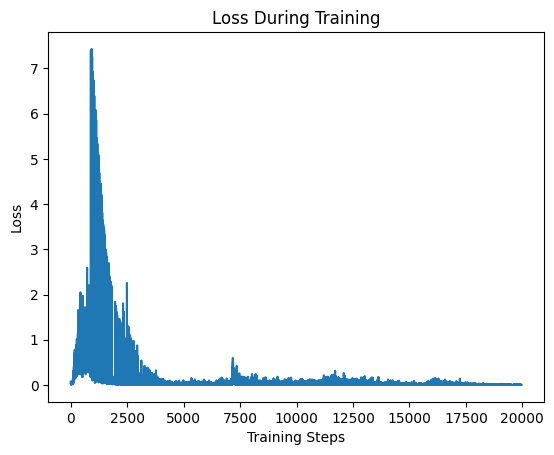

In [97]:
# After training, plot the losses
plt.plot(bandit.losses)
plt.title("Loss During Training")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.show()

In [116]:
import pandas as pd
from statistics import mean

In [85]:
sword_requirements = {
    "Beginner Sword": { Resource.WOOD: 1, Resource.METAL: 1},
    "Intermediate Sword": { Resource.WOOD: 2, Resource.METAL: 2},
    "Advanced Sword": { Resource.WOOD: 2, Resource.METAL: 2, Resource.GEM: 1},
    "Epic Sword": { Resource.WOOD: 2, Resource.METAL: 2, Resource.GEM: 2},
    "Ultimate Sword": { Resource.WOOD: 2, Resource.METAL: 2, Resource.GEM: 2, Resource.DRAGONSCALE: 1}
}

In [125]:
def run_simulation_for_selected_swords(selected_swords, trained_bandit, prices, budget, max_iterations=20000, num_runs=3):
    grid_search_results = {}
    for sword, requirements in selected_swords.items():
        avg_steps = []
        for x in range(3):
            # Convert requirements to context format for the bandit
            context = [0, 0, 0, 0]
            for resource, value in requirements.items():
                index = int(resource) - 1
                context[index] = value

            steps = 0
            print(context)
            while sum(context) != 0:
                arm = bandit.choose_arm(context)
                _ = bandit.get_reward(arm, context)
                context = bandit.new_context
                print(context)
                steps += 1
            # Record results for this set of requirements
            avg_steps.append(steps)
        grid_search_results[sword] = mean(avg_steps)
    return grid_search_results

adjusted_prices = {"wood": 1, "metal": 2, "gem": 5, "dragonscale": 10}
adjusted_budget = 1000  # Increased budget
max_iterations = 1000
results = run_simulation_for_selected_swords(sword_requirements, bandit, adjusted_prices, adjusted_budget, max_iterations)
print(results)

[1, 1, 0, 0]
[3 2 2 0]
[2 2 2 0]
[1 2 2 0]
[0 2 2 0]
[0 2 2 0]
[0 1 2 0]
[0 1 1 0]
[0 1 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 0 0]
[1, 1, 0, 0]
[1, 1, 0, 0]
[0, 1, 0, 0]
[0, 0, 0, 0]
[1, 1, 0, 0]
[0, 1, 0, 0]
[0, 1, 0, 0]
[0, 1, 0, 0]
[0, 1, 0, 0]
[0, 1, 0, 0]
[0, 1, 0, 0]
[0, 1, 0, 0]
[

{<Resource.WOOD: 1>: 1, <Resource.METAL: 2>: 1}
1
1
[1, 1, 0, 0]
[1, 1, 0, 0]
[1, 1, 0, 0]
[1, 1, 0, 0]
[1, 1, 0, 0]
[1, 1, 0, 0]
[1, 1, 0, 0]
[1, 1, 0, 0]
[1, 1, 0, 0]
[1, 0, 0, 0]
[0, 0, 0, 0]
{<Resource.WOOD: 1>: 2, <Resource.METAL: 2>: 2}
2
2
[0, 0, 0, 0]
{<Resource.WOOD: 1>: 1, <Resource.METAL: 2>: 1, <Resource.GEM: 3>: 1}
1
1
1
[0, 0, 0, 0]
{<Resource.WOOD: 1>: 2, <Resource.METAL: 2>: 2, <Resource.GEM: 3>: 2}
2
2
2
[2, 2, 1, 0]
[2, 2, 1, 0]
[2, 2, 0, 0]
[2, 2, 0, 0]
[2, 1, 0, 0]
[2, 1, 0, 0]
[2, 1, 0, 0]
[2, 0, 0, 0]
[2, 0, 0, 0]
[2, 0, 0, 0]
[2, 0, 0, 0]
[1, 0, 0, 0]
[0, 0, 0, 0]
{<Resource.WOOD: 1>: 2, <Resource.METAL: 2>: 2, <Resource.GEM: 3>: 2, <Resource.DRAGONSCALE: 4>: 1}
2
2
2
1
[0, 0, 0, 0]
{'Beginner Sword': 11, 'Intermediate Sword': 1, 'Advanced Sword': 1, 'Epic Sword': 13, 'Ultimate Sword': 1}


{'Beginner Sword': 18, 'Intermediate Sword': 11, 'Advanced Sword': 31, 'Epic Sword': 1, 'Ultimate Sword': 22}
